# Imports

In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

num_workers = 4
batch_size = 100

transform = transforms.ToTensor()

# train and test set
# FashionMNIST
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=num_workers)

# Visualize a batch

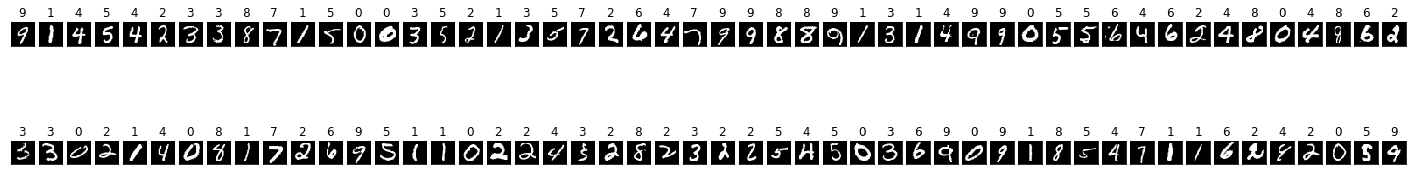

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

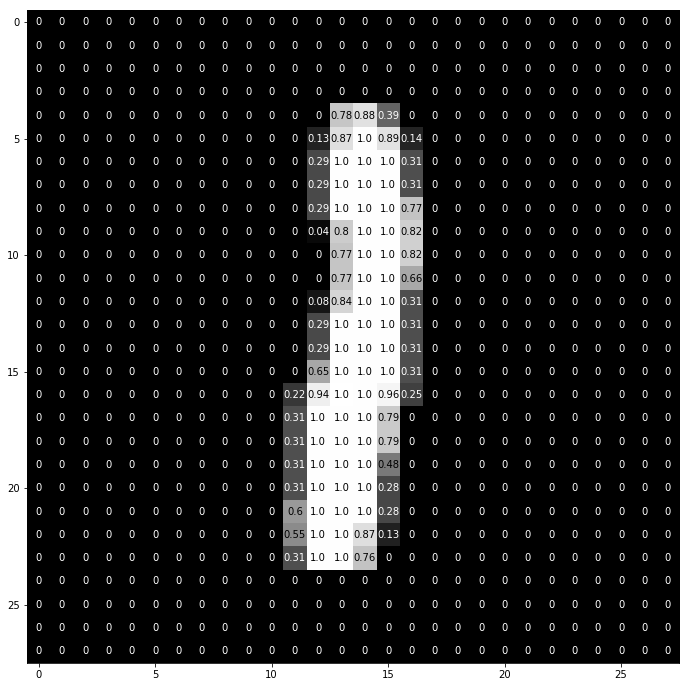

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


# Define the Network

In [5]:
class mNet(nn.Module):
    def __init__(self):
        super(mNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512,10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)
        return x

model = mNet()
print(model)

mNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [9]:
# Moreover, an object of type nn.Sequential has a forward() method,
# so if I have an input image x I can directly call y = simple_cnn(x) to obtain the scores for x.
class mNetSeq(nn.Module):
    def __init__(self):
        super(mNetSeq, self).__init__()
        # define with sequential here
        self.sequence1 = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.sequence2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc = nn.Linear(512,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.sequence1(x)
        x = self.sequence2(x)

        x = self.fc(x)

        return x

model2 = mNetSeq()
#print(model2)

mNetSeq(
  (sequence1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (sequence2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


In [0]:
class ConvmNet(nn.Module):
    def __init__(self):
        super(ConvmNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3,
                               stride=1, padding=0)
        self.conv2 = nn.Conv2d(10, 30, kernel_size=3,
                               stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.2)

        self.fc1 = nn.Linear(750, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512,10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.maxpool(F.leaky_relu(self.conv1(x), 0.02))
        x = self.dropout(x)

        x = self.maxpool(F.leaky_relu(self.conv2(x), 0.02))
        x = self.dropout(x)

        #print(self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Training Loop

In [27]:
!nvidia-smi

Sat Sep  7 09:04:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    56W / 149W |    423MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tqdm import tqdm_notebook as tqdm
import torch.backends.cudnn as cudnn

num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = False

model = ConvmNet()
model.to(device)

# loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)



model.train()

for epoch in tqdm(range(num_epochs)):

    train_loss = 0.0

    #####################
    ## train the model ##
    #####################

    for data, target in train_loader:

        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    scheduler.step(train_loss)

    print("Epoch: {} | Training Loss: {:.6f}".format(epoch, train_loss))


Epoch: 0 | Training Loss: 0.547244
Epoch: 1 | Training Loss: 0.207323
Epoch: 2 | Training Loss: 0.168982


In [32]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.cpu().item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of {}: {:.2f} ({}/{})'.format(
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): {:.2f} ({}/{})'.format(
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.021543

Test Accuracy of 0: 99.80 (978.0/980.0)
Test Accuracy of 1: 100.00 (1135.0/1135.0)
Test Accuracy of 2: 99.22 (1024.0/1032.0)
Test Accuracy of 3: 99.31 (1003.0/1010.0)
Test Accuracy of 4: 98.88 (971.0/982.0)
Test Accuracy of 5: 98.99 (883.0/892.0)
Test Accuracy of 6: 98.96 (948.0/958.0)
Test Accuracy of 7: 99.42 (1022.0/1028.0)
Test Accuracy of 8: 99.08 (965.0/974.0)
Test Accuracy of 9: 99.21 (1001.0/1009.0)

Test Accuracy (Overall): 99.30 (9930.0/10000.0)


# Visualize Test Results

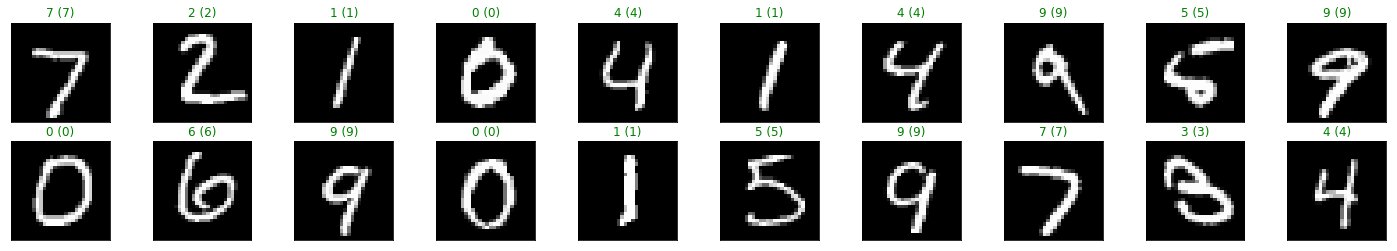

In [30]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()
preds = preds.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))